## Demonstration of AD on Verlet Integration
This notebook demonstrates how to use Automatic Differentiation to determine the gradients of the initial conditions of a dynamical system (in this case a damped oscillator). To do this, we will define a numerical routine ([Verlet Integration](https://en.wikipedia.org/wiki/Verlet_integration)) and then use Automatic Differentiation to back propagate the gradient information from the output (Total system energy) to the initial conditions.

In [3]:
%matplotlib inline
import torch
from pylab import *
import numpy as np

###############################################################################
N = 1000
t = np.linspace(0,10,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    #x = torch.tensor([0.0],requires_grad=True)
    #v = torch.zeros(N)
    Ef = 0
    x = np.zeros(N)
    v = np.zeros(N)
    E = np.zeros(N)
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v[0] = v0
    
    ###########################################################################
    # Do the Verlet Integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        vn = fac1*fac2*v0 - fac2*dt*x0 + fac2*dt*F[i]
        xn = x0 + dt*vn
        Ef = 0.5*(x0**2 + ((v0 + vn)/2.0)**2)
        v0 = vn
        x0 = xn
        # For Plotting/Debug

        v[i + 1] = vn
        x[i + 1] = xn
        E[i] = Ef

    Ef = 0.5*(x0**2 + v0**2)
    
    E[-1] = Ef
    
    ###########################################################################
    # return solution
    return ( (x0,v0,Ef) , (x,v,E) )

In [4]:
%matplotlib inline
import torch
from pylab import *
import numpy as np

###############################################################################
N = 1000
t = np.linspace(0,10,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    #x = torch.tensor([0.0],requires_grad=True)
    #v = torch.zeros(N)
    Ef = torch.tensor([0.0],requires_grad=True)
    x = np.zeros(N)
    v = np.zeros(N)
    E = np.zeros(N)
    
    ###########################################################################    
    # initial conditions
    with torch.no_grad():
        x[0] = x0
        v[0] = v0
    
    ###########################################################################
    # Do the Verlet Integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        vn = fac1*fac2*v0 - fac2*dt*x0 + fac2*dt*F[i]
        xn = x0 + dt*vn
        Ef = 0.5*(x0**2 + ((v0 + vn)/2.0)**2)
        v0 = vn
        x0 = xn
        # For Plotting/Debug
        with torch.no_grad():
            v[i + 1] = vn
            x[i + 1] = xn
            E[i] = Ef
    
    Ef = 0.5*(x0**2 + v0**2)
    with torch.no_grad():
        E[-1] = Ef
    
    ###########################################################################
    # return solution
    return ( (x0,v0,Ef) , (x,v,E) )

In [5]:
###############################################################################
# Do the actual numerical integration
F = zeros(N)

x_initial = torch.tensor([1.0], requires_grad = True)
v_initial = torch.tensor([1.0], requires_grad = True)
#gamma = torch.tensor([0.05], requires_grad = True)
gamma = torch.tensor([.05], requires_grad = True)
((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma) # x0 = 0.0, v0 = 1.0, gamma = 0.0

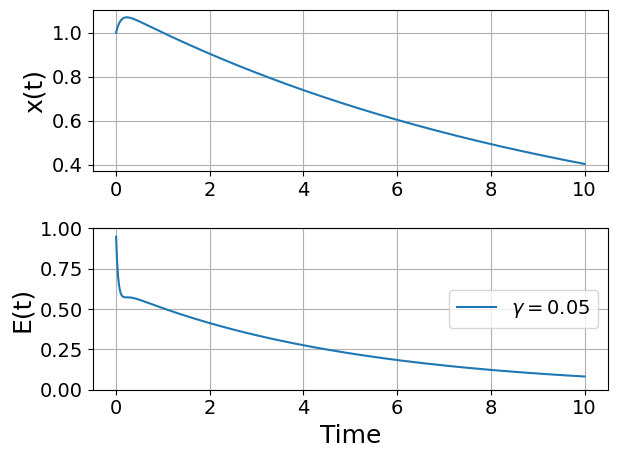

In [21]:
#((),(x2,v2,E2)) = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01
#((),(x2,v2,E2)) = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01

#((),(x3,v3,E3)) = integrate(F,0.0,1.0,0.4) # x0 = 0.0, v0 = 1.0, gamma = 0.5

###############################################################################
def plot_solution(x1,E1,gamma):
    rcParams["axes.grid"] = True
    rcParams['font.size'] = 14
    rcParams['axes.labelsize'] = 18
    figure()
    subplot(211)
    plot(t,x1)
    #plot(t,x2)
    #plot(t,x3)
    ylabel("x(t)")

    subplot(212)
    plot(t,E1,label=fr"$\gamma = {float(gamma):.2f}$")
    #plot(t,E2,label=r"$\gamma = 0.01$")
    #plot(t,E3,label=r"$\gamma = 0.5$")
    ylim(0,1.0)
    ylabel("E(t)")

    xlabel("Time")
    legend(loc="center right")

    tight_layout()

plot_solution(x1,E1,gamma)


In [7]:
print(Ef)
Ef.backward(retain_graph=True)

tensor([0.6137], grad_fn=<MulBackward0>)


Now let's print the gradient of the system Energy with respect to some of the initial conditions:

In [8]:
print(gamma.grad)
print(v_initial.grad)
print(x_initial.grad)

tensor([-5.9562])
tensor([0.6026])
tensor([0.6248])


In [9]:
print(vf)
vf.backward()

tensor([-0.2245], grad_fn=<AddBackward0>)


In [10]:
print(gamma.grad)
print(v_initial.grad)
print(x_initial.grad)

tensor([-4.7535])
tensor([-0.0437])
tensor([1.0466])


## Optimizing the Damping Coefficient via SGD and AD

First let's just get a visual intuition for how $\gamma$ affects the final energy:

In [22]:
num_gammas = 30
gamma_plot = np.logspace(-0.5,1.0,num_gammas)
Efs = np.zeros(num_gammas)
for i,g in enumerate(gamma_plot):
    ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,g)
    Efs[i] = Ef

Text(0, 0.5, 'E Final')

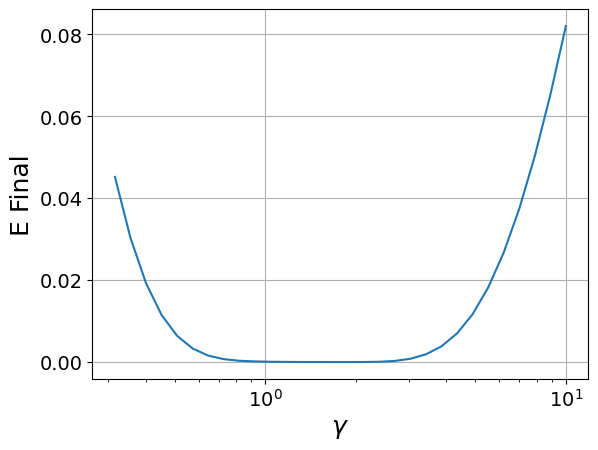

In [23]:
semilogx(gamma_plot,Efs)
xlabel(r'$\gamma$')
ylabel('E Final')

We can see that there is a pretty flat plateau from around $\gamma=1$ until around $\gamma=3$.

Now let's use our backward mode AD to actually optimize $\gamma$ directly by calling backward on the output of the final energy of the Verlet integration of the ODE:

In [24]:
# This part is just a helper library for plotting
def plot_optimization(initial_gamma, num_steps, optimizer, opt_kwargs={}):
    # Take an initial guess at the optimum:
    gamma = torch.tensor([initial_gamma], requires_grad=True)

    # Initialize the optimizer
    optimizer = optimizer([gamma], **opt_kwargs)

    steps = [ ] # Here is where we'll keep track of the steps
    # Take num_steps of the optimizer
    for i in range(num_steps):
        # This function runs an actual optimization step. We wrap it in closure so that optimizers
        # that take multiple function calls per step can do so -- e.g., LBFGS.
        def closure():
            # Get rid of the existing gradients on the tape
            optimizer.zero_grad()
            # Run the numerical integration -- this is the forward pass through the solver
            ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma) # x0 = 0.0, v0 = 1.0, gamma = 0.0
            # Compute the backward mode AD pass
            Ef.backward()
            return Ef
        # Now ask the optimizer to take a step
        optimizer.step(closure)
        
        # The below part is just for printing/plotting. We call torch.no_grad() here to signify that
        # we do not need to track this as part of the gradient operations. That is, these parts will not
        # be added to the computational graph or used for backward mode AD.
        with torch.no_grad():
            #print(gamma)
            # Run again just to plot the solution for this gamma
            ((xf,vf,Ef),(x1,v1,E1)) = integrate(F,x_initial,v_initial,gamma)
            #print(Ef)
            if num_steps>10 and i%3==0:
                plot_solution(x1,E1,gamma)
            # Add it to steps so that we can see/plot it later.
            steps.append(np.array(gamma.detach().numpy()))
            
    steps = np.array(steps)
    return steps

### ADAM Example

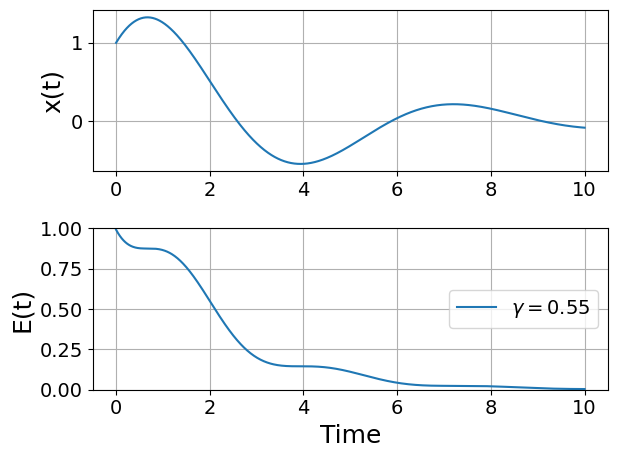

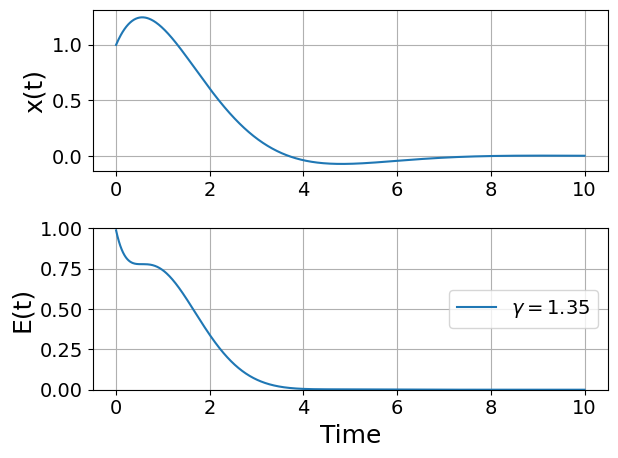

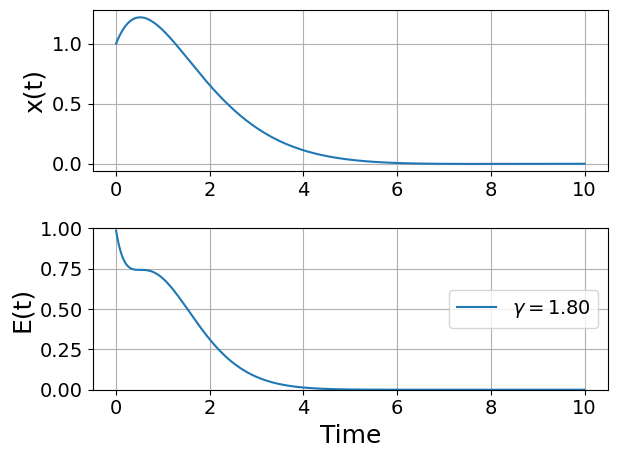

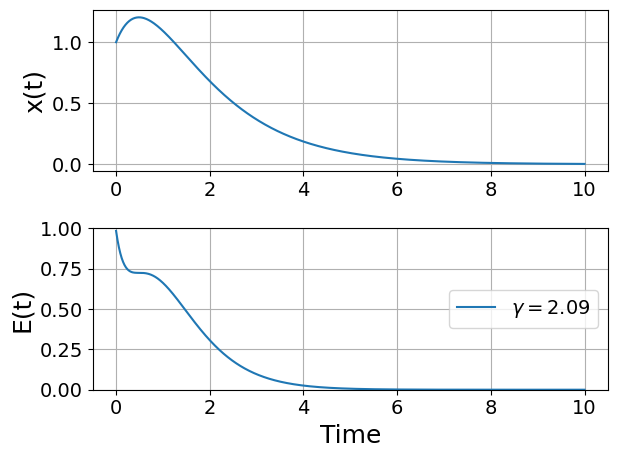

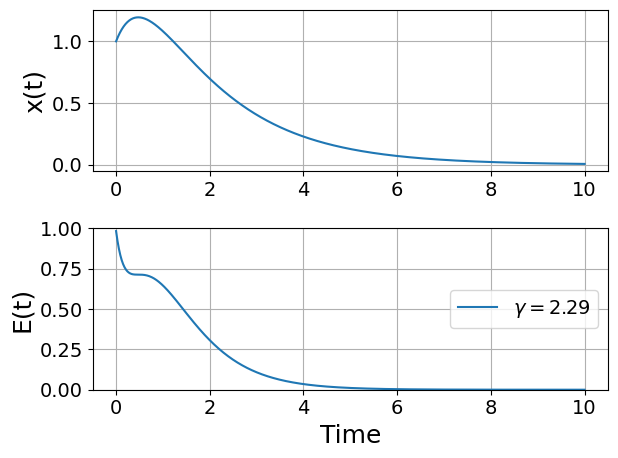

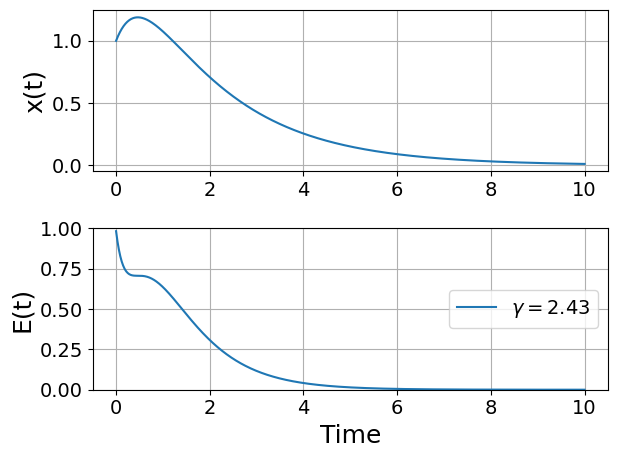

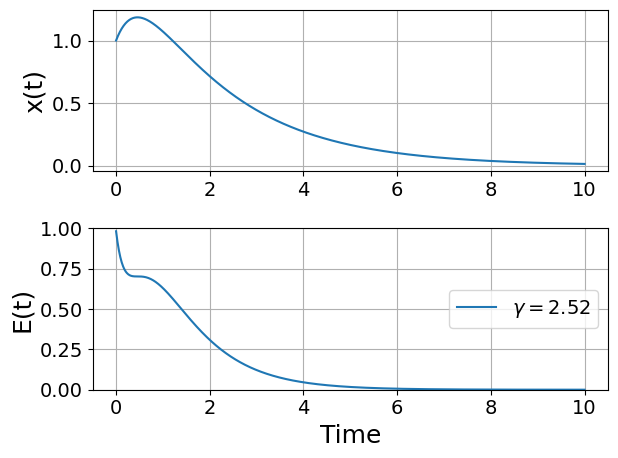

In [25]:
steps_Adam = plot_optimization(0.05, 20,
                              torch.optim.AdamW,
                              {'lr':0.5})

### SGD Example

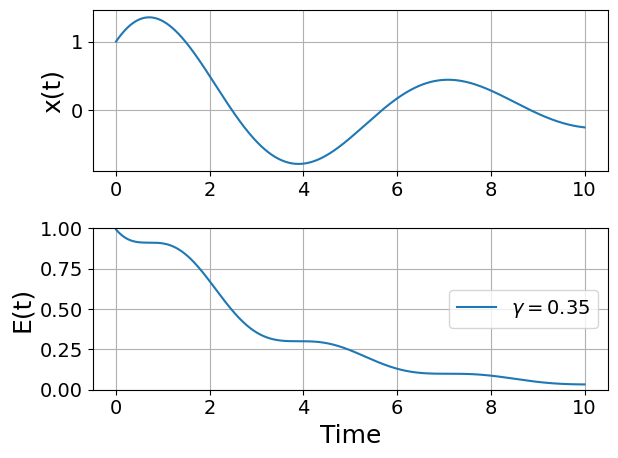

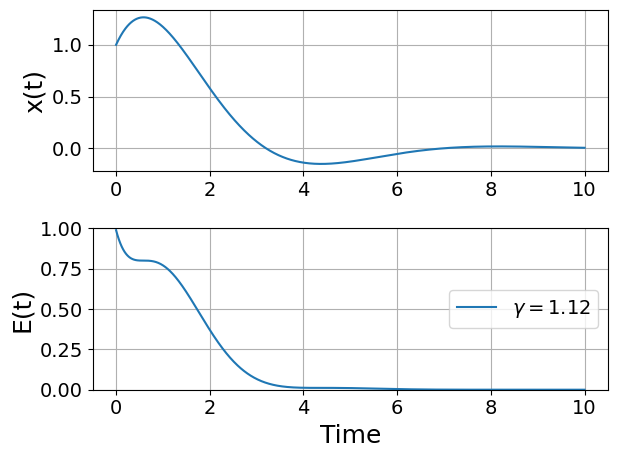

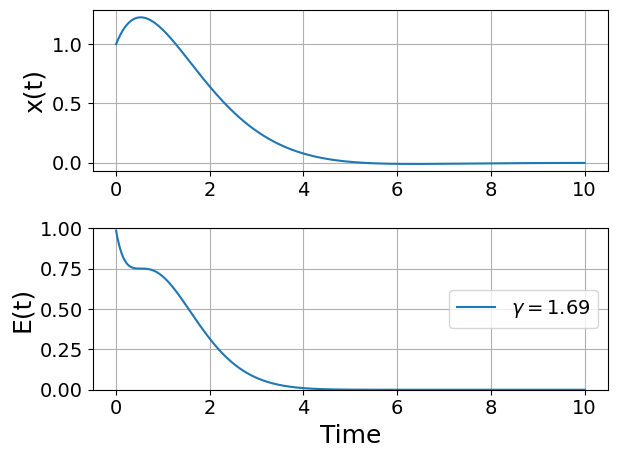

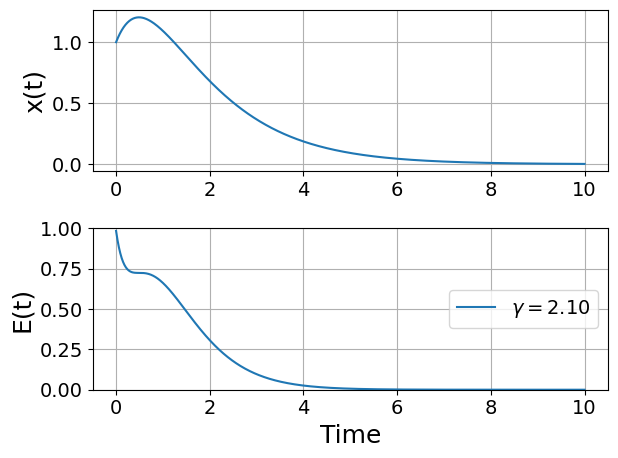

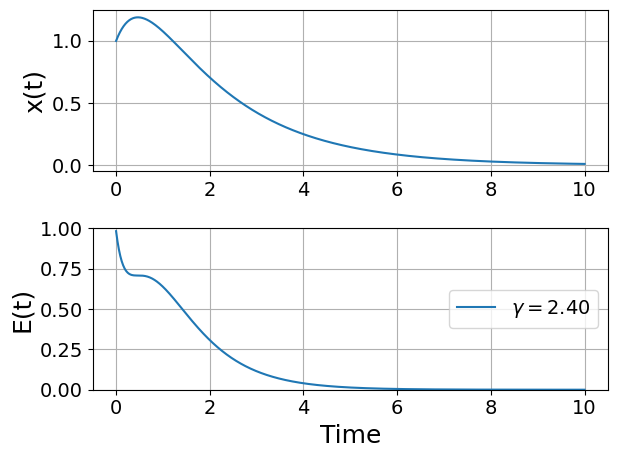

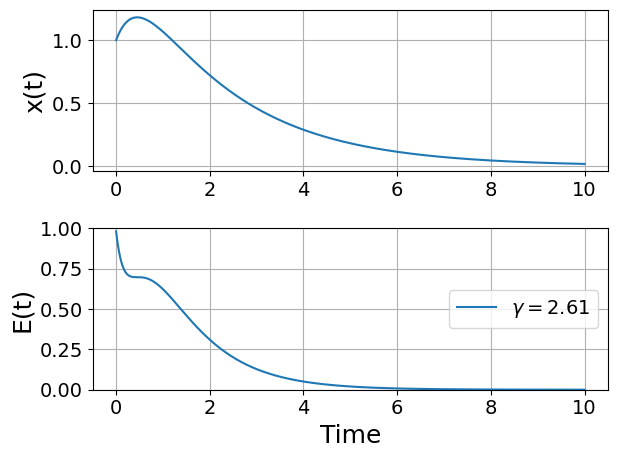

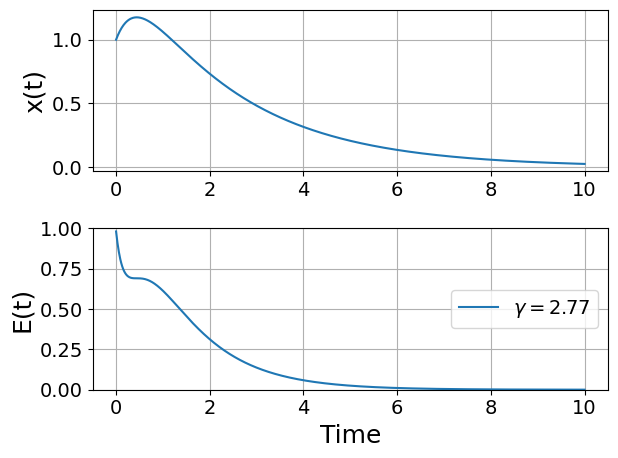

In [26]:
steps_SGD = plot_optimization(0.05, 20,
                              torch.optim.SGD,
                              {'lr':0.05,'momentum':0.9})

### LBFGS Example
(Warning: Per-run solves of LBFGS take a while, so don't set num_steps too high here)

In [27]:
steps_LBFGS = plot_optimization(0.05, 5,
                              torch.optim.LBFGS,
                             {'lr':0.3})

### Compare the steps taken

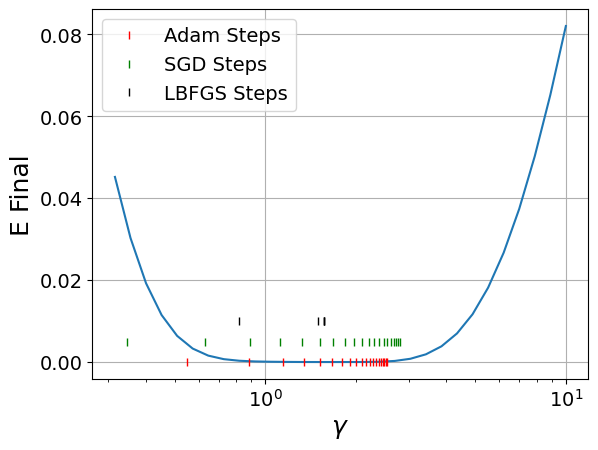

In [29]:
semilogx(gamma_plot,Efs)
steps_Adam = steps_Adam.flatten()
plot(steps_Adam,[0.0]*len(steps_Adam),'|', color = 'r', label = 'Adam Steps')
plot(steps_SGD,[0.005]*len(steps_SGD),'|', color = 'g', label = 'SGD Steps')
plot(steps_LBFGS,[0.01]*len(steps_LBFGS),'|', color = 'k', label = 'LBFGS Steps')
xlabel(r'$\gamma$')
ylabel('E Final')
legend()